# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.23 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
#Import everything else
from collections import deque
from collections import namedtuple

from math import log
import matplotlib.pyplot as plt

from navagents import BaseAgent
from navagents import DuelingAgent
from navagents import DuelingPriorityAgent
from navagents import OldAgent
from navagents import PriorityAgent
import numpy as np

import pandas as pd

from qnetworks import BaseQNetwork
from qnetworks import DuelingQNetwork
from qnetworks import OldQNetwork

import random
from replays import PrioritizedExperienceReplay
from replays import ReplayBuffer 

import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

## Training Loop
Every model needs a training loop.  Some frameworks, like Keras, bury it under a simple API so all one has to do is enter model.fit(), but PyTorch requires one to build the training loop oneself.  This has the disadvantage of being innately more difficult, but is ultimately more powerful as it gives one more control over how training proceeds.

In [6]:
def train(agent, num_episodes: int, init_epsilon: float=1.0) -> list:
    
    scores = []
    scores_window = deque(maxlen=100)
    for i_episode in range(num_episodes):
        env_info = env.reset(train_mode=True)[brain_name] #Reset environment for new episode
        state = env_info.vector_observations[0]           #Get current state
        score = 0
        
        eps = init_epsilon/(i_episode + 1)                #Exploration parameter, harmonic decay
    
        score = 0
        while True:
            action = agent.act(state, eps)                   #Agent takes an action
            env_info = env.step(action)[brain_name]          #Environment responds to Agent's action
            next_state = env_info.vector_observations[0]     #Get to next state
            reward = env_info.rewards[0]                     #Get the reward
            done = env_info.local_done[0]                    #Is the episode done?
            score += reward                                  #Update the score
            agent.step(state,action,reward,next_state,done)  #Agent takes a step, storing memory, learning, etc
            state = next_state                               #Update state
            if done:
                break
                
        scores_window.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            
    return scores
    

# Plotting Tool
The results will be much more easily visualized with plots.  This is being set here in the code so that the model results can be displayed sequentially, as opposed to having it after the model definitions which would require skipping ahead to run it then doubling back to make the plots.

In [7]:
def generate_plot(name: str, mode: str, scores: list, window: int) -> None:
    firstpass = np.where(np.array(scores) > 13.0)[0][0]
    print(f'First pass in Episode: {firstpass}')
    score_series = pd.Series(scores)
    windows = score_series.rolling(window)
    smoothedscores = windows.mean()
    firstave = np.where(np.array(smoothedscores) > 13.0)[0][0]
    print(f'First full pass in Episode: {firstave}')
    maxave = np.max(smoothedscores)
    maxind = smoothedscores.idxmax()
    print(f'Maximum Average Score: {maxave}')
    print(f'Maximum Episode Index: {maxind}')
    
    plt.plot(smoothedscores)
    plt.axvline(x=firstave)
    plt.axhline(y=13.0)
    plt.title(f'{name} with {mode} Experience Replay Average Scores')
    plt.xlabel('Episode')
    plt.ylabel(f'Average Score over {window} Episodes')
    plt.savefig(f'{name}_{mode}_Averages.png')
    return

# # Declare the Globals
The next cell establishes some global parameters for use throughout this project.

In [10]:
#Establish some important global parameters
ALPHA = 0.5             #Blending term for prioritized experience replay, [0,1], 0 = pure uniform distribution, 1 = no uniform
BETA = 1.0              #Exponent for importance sampling weight
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
LR = 5e-4               # learning rate
seed = 37               # random seed
TAU = 1e-3              # for soft update of target parameters
UPDATE_EVERY = 4        # how often to update the network
WINDOW_SIZE = 100       # window size for moving average


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
basehypers = {'BATCH_SIZE': BATCH_SIZE, 'BUFFER_SIZE': BUFFER_SIZE, 
              'GAMMA': GAMMA, 'LR': LR, 'TAU': TAU, 'UPDATE_EVERY': UPDATE_EVERY}

In [10]:
old_agent = OldAgent(state_size, action_size, seed, basehypers, device)

In [11]:
start_old = time.perf_counter()
oldagentscores = train(old_agent, 1001, 1.0)
torch.save(old_agent.qnetwork_primary.state_dict(), 'old_agent_checkpoint.pth')
elapsed_old = time.perf_counter() - start_old
print(f'Old Agent elapsed time: {elapsed_old: .3f}')

Episode 0	Average Score: 0.00
Episode 100	Average Score: 3.38
Episode 200	Average Score: 8.77
Episode 300	Average Score: 11.38
Episode 400	Average Score: 13.58
Episode 500	Average Score: 15.47
Episode 600	Average Score: 16.12
Episode 700	Average Score: 16.58
Episode 800	Average Score: 16.10
Episode 900	Average Score: 15.92
Episode 1000	Average Score: 15.67
Old Agent elapsed time:  1249.031


First pass in Episode: 56
First full pass in Episode: 359
Maximum Average Score: 16.83
Maximum Episode Index: 720


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


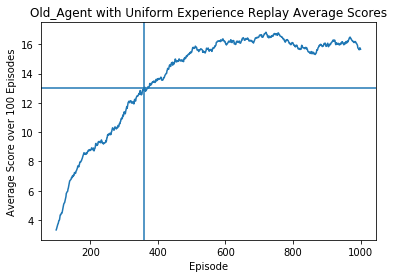

In [33]:
generate_plot('Old_Agent', 'Uniform', oldagentscores, WINDOW_SIZE)

In [19]:
base_agent = BaseAgent(state_size, action_size, seed, basehypers, device)

In [20]:
start_base = time.perf_counter()
baseagentscores = train(base_agent, 1001, 1.0)
torch.save(base_agent.qnetwork_primary.state_dict(), 'base_agent_checkpoint.pth')
elapsed_base = time.perf_counter() - start_base
print(f'Base Agent Elapsed Time: {elapsed_base: .3f}')

Episode 0	Average Score: 1.00
Episode 100	Average Score: 2.79
Episode 200	Average Score: 8.25
Episode 300	Average Score: 11.83
Episode 400	Average Score: 14.10
Episode 500	Average Score: 15.70
Episode 600	Average Score: 15.48
Episode 700	Average Score: 15.22
Episode 800	Average Score: 16.33
Episode 900	Average Score: 16.30
Episode 1000	Average Score: 16.95
Base Agent Elapsed Time:  1318.864


First pass in Episode: 98
First full pass in Episode: 331
Maximum Average Score: 17.18
Maximum Episode Index: 973


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


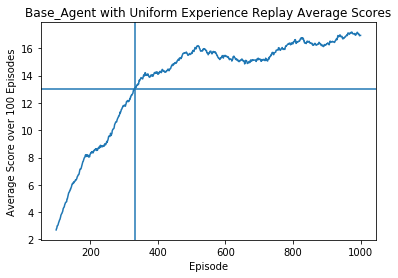

In [34]:
generate_plot('Base_Agent', 'Uniform', baseagentscores, WINDOW_SIZE)

In [12]:
dueling_agent = DuelingAgent(state_size, action_size, seed, basehypers, device)

In [13]:
start_duel = time.perf_counter()
duelingagentscores = train(dueling_agent, 1001, 1.0)
torch.save(dueling_agent.qnetwork_primary.state_dict(), 'dueling_agent_checkpoint.pth')
elapsed_duel = time.perf_counter() - start_duel
print(f'Dueling Agent Elapsed Time: {elapsed_duel: .3f}')

Episode 0	Average Score: 0.00
Episode 100	Average Score: 2.12
Episode 200	Average Score: 6.92
Episode 300	Average Score: 10.60
Episode 400	Average Score: 12.45
Episode 500	Average Score: 16.25
Episode 600	Average Score: 15.67
Episode 700	Average Score: 16.50
Episode 800	Average Score: 16.22
Episode 900	Average Score: 17.22
Episode 1000	Average Score: 16.86
Dueling Agent Elapsed Time:  1396.251


First pass in Episode: 91
First full pass in Episode: 338
Maximum Average Score: 17.45
Maximum Episode Index: 724


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


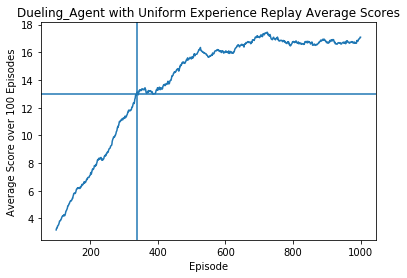

In [37]:
generate_plot('Dueling_Agent', 'Uniform', duelingagentscores, WINDOW_SIZE)

In [9]:
priorityhypers = {'ALPHA': ALPHA, 'BETA': BETA, 'BATCH_SIZE': BATCH_SIZE, 'BUFFER_SIZE': BUFFER_SIZE, 
                  'GAMMA': GAMMA, 'LR': LR, 'TAU': TAU, 'UPDATE_EVERY': UPDATE_EVERY}

In [10]:
priority_agent = PriorityAgent(state_size, action_size, seed, priorityhypers, device)

In [ ]:
start_priority = time.perf_counter()
priorityagentscores = train(priority_agent, 1001, 1.0)
torch.save(priority_agent.qnetwork_primary.state_dict(), 'priority_agent_checkpoint.pth')
elapsed_priority = time.perf_counter() - start_priority
print(f'Priority Agent Elapsed Time: {elapsed_priority: .3f}')

Episode 0	Average Score: 0.00
Episode 100	Average Score: 3.42
Episode 148	Average Score: 4.34

In [ ]:
generate_plot('Base_Agent', 'Prioritized', priorityagentscores, WINDOW_SIZE)

In [ ]:
dueling_priority_agent = DuelingPriorityAgent(state_size, action_size, seed, priorityhypers, device)

In [ ]:
start_DPA = time.perf_counter()
DPA_scores = train(dueling_priority_agent, 1001, 1.0)
torch.save(dueling_priority_agent.qnetwork_primary.state_dict(), 'dueling_priority_agent_checkpoint.pth')
elapsed_DPA = time.perf_counter() - start_DPA
print(f'Dueling Priority Agent Elapsed Time: {elapsed_DPA: .3f}')

In [ ]:
generate_plot('Dueling_Agent', 'Prioritized', DPA_scores, WINDOW_SIZE)

In [ ]:
#Politely close the environment when we are done
env.close()